# Mapping the _P. aeruginosa_ cell surface with Phage-seq (`fig-mapping`)



Note: this notebook generates the panels of this figure showing 3D ordination plots. A [separate notebook `fig-suppl-learning.ipynb`](./fig-suppl-learning.ipynb) shows the classifier training and receiver-operator curves 

## Ordinations

### PCA/TSVD

In [1]:
import nbseq
import os

# change working directory to `./panning-massive` for simplicity of access to feature tables, etc
# make sure we don't do this twice, or we'll end up in the wrong place and be very confused
if 'dir_changed' not in globals():
    os.chdir('../../')
    dir_changed = True

In [2]:
import pandas as pd, numpy as np

import matplotlib.pyplot as plt

In [3]:
import plotly.express as px
import plotly.graph_objects as go

In [4]:
import nbseq.viz.ord
from nbseq.viz.ord import *

import nbseq.ordination

In [5]:
plt.rcParams.update({
    "font.family":"sans",
    'font.size': 5,
    'svg.fonttype':'none',
})

In [6]:
%config InlineBackend.figure_formats = ['svg']

In [7]:
ex = nbseq.Experiment.from_files(ft_aa=None,
                                 tree_cdr3=None, tree_aa=None) #'intermediate/cdr3/features/all/alpaca/asvs.nwk')

Loading experiment panning-massive from '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-massive'...
- Reading metadata from config/metadata_full.csv ...
- Reading phenotypes from config/phenotypes.csv ...
- Reading Config from config/config.yaml ...
- Warning: sqlite database '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-massive/intermediate/aa/asvs.db' does not exist
- Reading feature data for table 'cdr3' from results/tables/cdr3/asvs.csv (3.8 MB)...
- Reading cdr3 feature table from results/tables/cdr3/feature_table.biom (29.0 MB)...
- Warning: mmseqs2 database for space 'aa' at 'intermediate/aa/features_db/features' does not exist!
- Warning: mmseqs2 database for space 'cdr3' at 'intermediate/cdr3/features_db/features' does not exist!
- Reading enrichment model (conditional ECDF) for space cdr3 from results/tables/cdr3/enrichment/null/ecdf.pickle (307.6 kB)...
Finished in 0.71 seconds


In [8]:
ex.fts.cdr3.obs['OprOP'] = np.nan

Add/cleanup metadata

In [9]:
nbseq.ft.add_metadata(ex.fts.cdr3, 'reads', 'nfeatures');
# nbseq.ft.add_metadata(ex.fts.aa,   'reads', 'nfeatures');

ex.fts.cdr3.obs['category'] = (ex.fts.cdr3.obs['category']
                               .fillna('library')
                               .replace({'alginate':'EPS', 'biofilm':'EPS', 'c-di-GMP':'EPS'}))

ex.fts.cdr3.obs['background_CS'] = ex.fts.cdr3.obs.background_CS.fillna('N/A')
ex.fts.cdr3.obs['background_S'] = ex.fts.cdr3.obs.background_S.fillna('N/A')

ex.fts.cdr3.obs.loc[ex.fts.cdr3.obs['cond_S'].isna() & (ex.fts.cdr3.obs['expt'] == '027i.lib'),'cond_S'] = 'library'
ex.fts.cdr3.obs['cond_S'] = ex.fts.cdr3.obs.cond_S.fillna('LB')
ex.fts.cdr3.obs.loc[ex.fts.cdr3.obs['cond_CS'].isna() & (ex.fts.cdr3.obs['expt'] == '027i.lib'),'cond_CS'] = 'library'
ex.fts.cdr3.obs['cond_CS'] = ex.fts.cdr3.obs.cond_CS.fillna('LB')


make_growth_statement = lambda x: x if x in ['library', 'scrape'] else ('liquid stationary' if x == 'stationary' else 'liquid exponential')

ex.fts.cdr3.obs['growth_S']  = ex.fts.cdr3.obs['cond_S'].apply(make_growth_statement)
ex.fts.cdr3.obs['growth_CS'] = ex.fts.cdr3.obs['cond_CS'].apply(make_growth_statement)

from nbseq.viz.utils import shorten_descriptions
shorten_descriptions(ex.obs);
shorten_descriptions(ex.fts.cdr3.obs);
ex.fts.cdr3.obs['desc_short_ml'] = ex.fts.cdr3.obs['desc_short'].str.replace("/","\n")

# ex.fts.aa.obs = ex.fts.cdr3.obs

Load scran-normalized feature table

In [10]:
ft_cdr3_norm = nbseq.ft.read('results/tables/cdr3/transformed/scran/feature_table.biom')
ft_cdr3_norm = nbseq.ft.join_metadata(ft_cdr3_norm, ex.fts.cdr3.obs, axis='obs')
ft_cdr3_norm.obs.index.name = 'ID'

ft_cdr3_norm_r5 = nbseq.ft.query(ft_cdr3_norm, '(expt == "027i.lib") | (r == 5 & kind == "+" & io == "i")', axis='sample')

In [11]:
def make_data_ordn(ordn, obs, fields, dims={0:'PC1', 1: 'PC2', 2: 'PC3'}, index_name='sample', biplot=False):
    """ Create Source Data file for ordination plots
    """
    if isinstance(dims, list):
        dims = { n:f'PC{n+1}' for n in dims }
        
    df_ordn = ordn.samples[list(dims.keys())].rename(columns=dims)
    if isinstance(fields, list):
        fields = dict(zip(fields, fields))

    
    df_obs = obs[list(fields.keys())]
    df = df_ordn.join(df_obs).rename(columns=fields)

    if biplot:
        df_biplot = ordn.biplot_scores[list(dims.keys())].rename(columns=dims, index=lambda x: f'{x} (biplot)')
        df = pd.concat([df, df_biplot]).fillna('')
    
    if not df.index.name:
        df.index.name = index_name
    return df

#### All rounds

In [12]:
%%bash
mkdir -p results/plots/ord/
mkdir -p results/tables/figures/ord/

In [13]:
ftf_all = nbseq.ft.query(ft_cdr3_norm,"(expt == '027i.lib') | (kind == '+' & io == 'i')", axis='obs')

In [14]:
ord_skl_all, ord_skbio_all = nbseq.ordination.ordinate(ftf_all, method='TSVD', **{ 'n_components':100 })

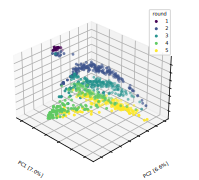

In [15]:
fig, ax = ordination_mpl(ord_skbio_all, ftf_all.obs, color='r',
                         s=4,
                         cmap=discrete_cmap(5,'viridis'), 
                         color_order=sorted(ftf_all.obs['r'].unique()),
                         camera=dict(elev=30, azim=135, roll=0), 
                         fig_kw = dict(figsize=(3,3)));
plt.legend(title="round")
plt.savefig("results/plots/ord/panning-massive-rounds.svg")

In [16]:
(make_data_ordn(ord_skbio_all, ftf_all.obs, {'r':'round'})
 .to_csv('results/tables/figures/ord/panning-massive-rounds.csv', index=True))

#### Final round (round 5 input)

In [17]:
ftf = nbseq.ft.query(ft_cdr3_norm_r5,"~(ID in ['08-H12'])", axis='obs')

ord_skl, ord_skbio = nbseq.ordination.ordinate(ftf, method='TSVD', **{ 'n_components':100 })

In [18]:
grads_default_colors = [
    (170, 170, 170),
    (250,  60,  60),
    (  0, 220,   0),
    ( 30,  60, 255),
    (  0, 200, 200),
    (240,   0, 130),
    (230, 220,  50),
    (240, 130,  40),
    (160,   0, 200),
    (160, 230,  50),
    (  0, 160, 255),
    (230, 175,  45),
    (  0, 210, 140),
    (130,   0, 220),
]

grads_default = LinearSegmentedColormap.from_list(
    'grads_default', 
    [(r/255.0, g/255.0, b/255.0) for (r,g,b) in grads_default_colors], 
    # [f'rgb({r},{g},{b},255)' for (r,g,b) in grads_default_colors], 
    len(grads_default_colors))

In [19]:
color_order = [
    'library', 'general', 'clinical isolate', 
    'regulator','QS','iron',
    'efflux','porin', 'secretion',
    'motility', 'fimbrae',
    'LPS', 'EPS', 
]

In [20]:
plotly_cmap_colors = [
    (226, 226, 226),
    (86, 86, 86),
    (255, 100, 14),
    (254, 0, 250),
    
    
    (120, 42, 182),
    (222, 160, 253),
    (50, 131, 254),
    (50, 90, 155),
    
    (255, 200, 50),

    (28, 131, 86),
    (22, 255, 50),

    (133, 102, 13),
    (247, 225, 160),

    (196, 69, 28),
    (248, 161, 159),

    (28, 190, 79),
	# (170, 13, 254),
    # (254, 175, 22),
]
plotly_cmap = LinearSegmentedColormap.from_list(
    'plotly_cmap', 
    [(r/255.0, g/255.0, b/255.0) for (r,g,b) in plotly_cmap_colors], 
    # [f'rgb({r},{g},{b},255)' for (r,g,b) in grads_default_colors], 
    len(plotly_cmap_colors))

plotly_cmap_dict = dict(zip(color_order, ((r/255.0, g/255.0, b/255.0) for (r,g,b) in plotly_cmap_colors)))
plotly_cmap_dict[None] = (0.5,0.5,0.5)

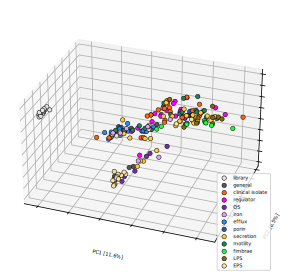

In [21]:
fig, ax = ordination_mpl(
    ord_skbio,            
    ftf.obs, color='category', cmap=plotly_cmap_dict, color_order = color_order,
    alpha=1,edgecolors='#000000',
    linewidth=0.5,
    camera=dict(elev=30, azim=110, roll=0));
plt.legend(loc='lower right')

plt.savefig("results/plots/ord/026m2-categories.svg")

In [22]:
(make_data_ordn(ord_skbio, ftf.obs, {'name':'selection', 'r':'round', 'category':'antigen category', 'growth_S':'growth condition', 'desc_short': 'description'})
 .to_csv('results/tables/figures/ord/026m2-categories.csv', index=True))

Uncomment to show an interactive version of this plot with Plotly

In [23]:
# fig = nbseq.viz.ord.ordination_plotly(ord_skbio, 
#                                       ftf.obs, 
#                                       color='category', 
#                                       hover_name='description',
#                                       hover_data=['strain_S'], width=800,height=600)
# fig.update_traces(
#     marker_size=4,
#     marker_line_width=2,
#     marker_line_color='DarkSlateGrey',
#     overwrite=True
# )
# fig.update_layout(
#     legend= {'itemsizing': 'constant'},
#     scene_camera=dict(
#         eye=dict(x=-1, y=1, z=1),
#         center=dict(x=0, y=0, z=0),
#     )
# )
# fig

In [24]:
# fig.write_image('results/plots/ord/026m2-category.png', scale=2.0)
# fig.write_image('results/plots/ord/026m2-category.svg', scale=2.0)

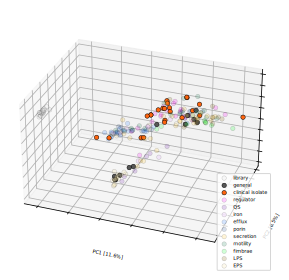

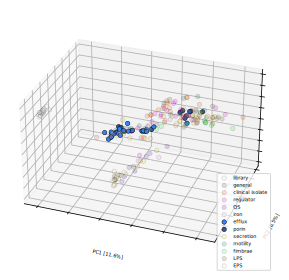

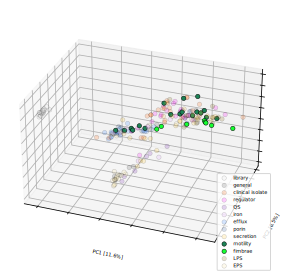

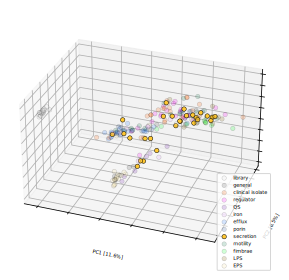

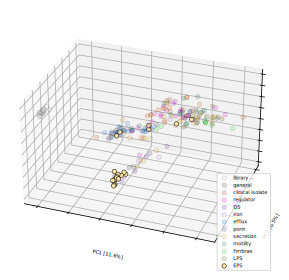

In [25]:
subsets = {
    'clinical': ['general','clinical isolate'],
    'efflux': ['efflux', 'porin'],
    'motility': ['motility', 'fimbrae'],
    'secretion': ['secretion'],
    'capsule': ['EPS'],
}

for subset_name, subset_categories in subsets.items():
    color_kws = {}
    for k in color_order:
        if k in subset_categories:
            color_kws[k] = dict(alpha=1)
        else:
            color_kws[k] = dict(alpha=0.2)
    
    fig, ax = ordination_mpl(
        ord_skbio,            
        ftf.obs, color='category', cmap=plotly_cmap, color_order = color_order,
        edgecolors='#000000',
        color_kws = color_kws,
        linewidth=0.5,
        camera=dict(elev=30, azim=110, roll=0));
    plt.legend(loc='lower right')
    plt.savefig(f"results/plots/ord/026m2-cat-{subset_name}.svg")

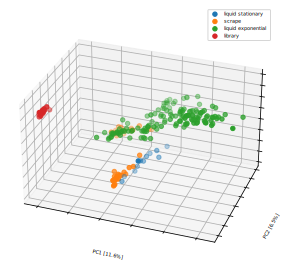

In [26]:
fig, ax = ordination_mpl(ord_skbio, 
               ftf.obs, color='growth_S');
plt.legend()
ax.view_init(elev=30, azim=110, roll=0)
plt.savefig("results/plots/ord/026m2-growth.svg")

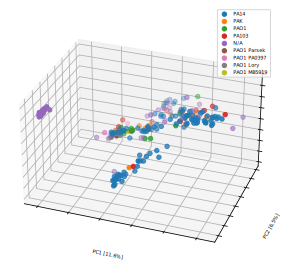

In [27]:
fig, ax = ordination_mpl(ord_skbio, 
               ftf.obs, color='background_S');
plt.legend()
ax.view_init(elev=30, azim=110, roll=0)
plt.savefig("results/plots/ord/026m2-background.svg")

Uncomment to show an interactive version of this plot with Plotly

In [28]:
# fig = ordination_plotly(ord_skbio, ftf.obs,dims=[0,1,2], 
#                   # color='background_S', 
#                   color='growth_S', 
#                         # text='antigen', 
#                         hover_name='antigen', hover_data=['index','cond_S', 'desc_short' ], 
#                   width=800, height=600)

# fig.update_traces(
#     marker_size=4,
#     marker_line_width=2,
#     marker_line_color='DarkSlateGrey',
#     overwrite=True
# )
# fig.update_layout(
#     legend= {'itemsizing': 'constant'},
#     scene_camera=dict(
#         eye=dict(x=-1, y=1, z=1),
#         center=dict(x=0, y=0, z=-0.1),
#     )
# )

In [29]:
# fig = nbseq.viz.ord.ordination_plotly(ord_skbio, 
#                                       ftf.obs, color='growth_S', 
#                                       hover_name='description', 
#                                       color_discrete_sequence=px.colors.qualitative.D3,
#                                       category_orders={'growth_S': ['library', 'scrape', 'liquid stationary', 'liquid exponential']},
#                                       width=800,height=600)
# # fig.update_traces(
# #     marker=dict(
# #         size=6,
# #         line=dict(width=2,
# #                   color='DarkSlateGrey'))
# # )
# fig.update_traces(
#     marker_size=4,
#     marker_line_width=2,
#     marker_line_color='DarkSlateGrey',
#     overwrite=True
# )
# fig.update_layout(
#     legend= {'itemsizing': 'constant'},
#     scene_camera=dict(
#         eye=dict(x=-1, y=1, z=1),
#         center=dict(x=0, y=0, z=0),
#     )
# )
# fig

In [30]:
# fig.write_image('results/plots/ord/026m2-growth.png', scale=4.0)

#### Enrichment

In [31]:
def summarize_filtering(ft_in, ft_out, min_abundance=None, min_prevalence=None):
    print("Retained:")
    print(f"{ft_out.shape[1]:>12.0f} = {ft_out.shape[1] / ft_in.shape[1]:>4.0%} features")
    print(f"{ft_out.X.sum():>12.0e} = {ft_out.X.sum() / ft_in.X.sum():>4.0%} reads")

ft_cdr3_high = nbseq.ft.filter_abundance_prevalence(ex.fts.cdr3, min_abundance=10, min_prevalence=5)
summarize_filtering( ex.fts.cdr3, ft_cdr3_high)

ft_cdr3_high_r = nbseq.ft.to_relative(ft_cdr3_high)

Retained:
       16231 =  28% features
       4e+08 =  99% reads


In [32]:
# calculate log10(enrichment) in anndata matrix
enr_cdr3 = nbseq.select.enr(ft_cdr3_high, 'ad')
enr_cdr3.X = nbseq.utils.sparse_drop_na(enr_cdr3.X)
enr_cdr3.X.data = np.log1p(enr_cdr3.X.data)

In [33]:
# drop some outlier samples
enr_outliers = ['027i.1.B1.1','027i.1.B5.1','027i.1.A1.1','027i.1.A2.1','027i.1.C1.1','027i.1.C2.1',
               '027i.2.E1.1','027i.2.D5.1'
               ]

enr_cdr3 = nbseq.ft.query(enr_cdr3, f"~(name in {enr_outliers})", axis='sample')

In [34]:
ord_skl_enr, ord_skbio_enr = nbseq.ordination.ordinate(enr_cdr3, method='TSVD', **{ 'n_components':100 })

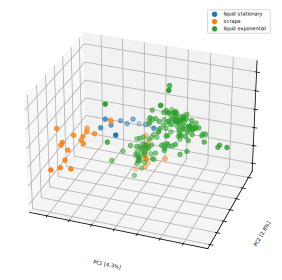

In [35]:
fig, ax = ordination_mpl(ord_skbio_enr, 
               enr_cdr3.obs, color='growth_S');
plt.legend()
ax.view_init(elev=30, azim=110, roll=0)
plt.savefig("results/plots/ord/026m2-enr-growth.svg")

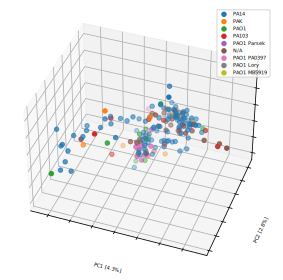

In [36]:
fig, ax = ordination_mpl(ord_skbio_enr, 
               enr_cdr3.obs, color='background_S');
plt.legend()
ax.view_init(elev=40, azim=110, roll=0)
plt.savefig("results/plots/ord/026m2-enr-background.svg")

In [37]:
(make_data_ordn(ord_skbio_enr, enr_cdr3.obs, {'category':'antigen category', 'growth_S':'growth condition', 'desc_short': 'description'}, index_name='selection')
 .to_csv('results/tables/figures/ord/026m2-enr.csv', index=True))

Ordination of subsets

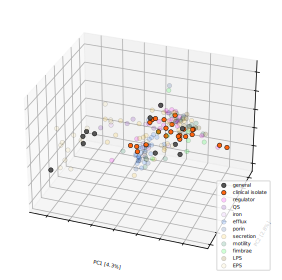

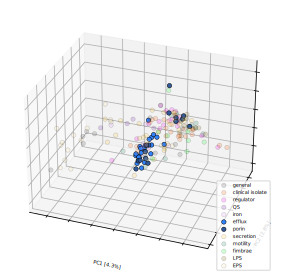

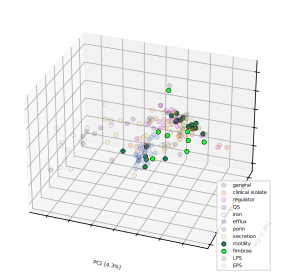

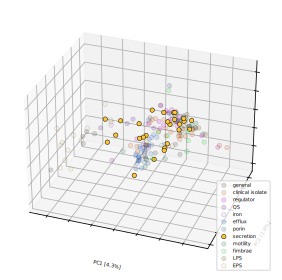

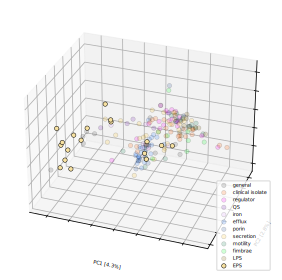

In [38]:
subsets = {
    'clinical': ['general','clinical isolate'],
    'efflux': ['efflux', 'porin'],
    'motility': ['motility', 'fimbrae'],
    'secretion': ['secretion'],
    'capsule': ['EPS'],
}

for subset_name, subset_categories in subsets.items():
    color_kws = {}
    for k in color_order:
        if k in subset_categories:
            color_kws[k] = dict(alpha=1)
        else:
            color_kws[k] = dict(alpha=0.2)
    
    fig, ax = ordination_mpl(
        ord_skbio_enr,            
        enr_cdr3.obs, color='category', cmap=plotly_cmap, color_order = color_order,
        edgecolors='#000000',
        color_kws = color_kws,
        linewidth=0.5,
        camera=dict(elev=30, azim=110, roll=0));
    plt.legend(loc='lower right')
    plt.savefig(f"results/plots/ord/026m2-enr-cat-{subset_name}.svg")

Uncomment to show an interactive version of this plot with Plotly

In [39]:
# from nbseq.viz.ord import ordination_plotly

# fig = ordination_plotly(ord_skbio_enr, enr_cdr3.obs,dims=[0,1,2], 
#                   color='growth_S', 
#                         # text='antigen', 
#                         hover_name='antigen', hover_data=['index','cond_S', 'desc_short' ], 
#                   width=800, height=600)

# fig.update_traces(
#     marker_size=4,
#     marker_line_width=2,
#     marker_line_color='DarkSlateGrey',
#     overwrite=True
# )
# fig.update_layout(
#     legend= {'itemsizing': 'constant'},
#     scene_camera=dict(
#         eye=dict(x=-1, y=1, z=1),
#         center=dict(x=0, y=0, z=-0.1),
#     )
# )

### CCA

In [40]:
ags = ['FliC','FlgEHKL','PilQ','T3SS','OprM']

In [41]:
Y = enr_cdr3.obs[ags].replace(-1, 0).fillna(0)

df = enr_cdr3.to_df()

# drop zero-variance VHHs
df = df.loc[:, df.var(axis=0) > 0]

In [42]:
import skbio.stats.ordination
ordn = skbio.stats.ordination.cca(df, Y)

In [43]:
def plot_ordn_ag(antigen, camera=dict(),lim=0.3, zoom=1, **kwargs):
    ag_to_category = {
        'FliC':'motility',
        'T3SS':'secretion',
        'OprM':'porin',
        'PilQ':'motility',
        'FlgEHKL':'motility',
    }

    biplot_colors = {k: (r/255.,g/255.,b/255.) for k,(r,g,b) in {
                             'FliC': (28, 131, 86),
                             'FlgEHKL': (28, 190, 79),
                             'PilQ':(22, 255, 50),
                             'T3SS':(255, 200, 50),
                             'OprM':(50, 90, 155),
                             'OprN':(50, 90, 155),
                             'OprJ':(50, 90, 155),
                             None: (128, 128, 128),
                         }.items()}

    if lim is not None:
        kws = dict(
            xlim=[-lim,lim],
            ylim=[-lim,lim],
            zlim=[-lim,lim],
        )
    else:
        kws = dict()

    kws = {**kwargs, **kws}
    
    fig, ax = ordination_mpl(ordn, ex.selection_metadata.fillna(0), color=antigen, 
                        color_order = [-1,0,float('nan'),1],
                        cmap={
                            1: plotly_cmap_dict[ag_to_category[antigen]],
                            None: (0.5,0.5,0.5)
                        },   
                        color_kws = {-1: {'alpha':0.2}, 0: {'alpha':0.2}},
                        alpha=1,edgecolors='#000000',
                        linewidth=0.5,
                         s=25,
                         # cmap=discrete_cmap(5,'viridis'), 
                         # color_order=sorted(ftf_all.obs['r'].unique()),
                         show_ticks=True,
                         biplot=True,
                         biplot_cmap={
                             antigen:biplot_colors[antigen],
                             None: biplot_colors[None],
                         },
                         camera={**dict(elev=20, azim=60, roll=0), **camera}, 
                             dims=['CCA1','CCA2','CCA3'],
                         fig_kw = dict(figsize=(3,3)), zoom=zoom, **kws);
    return fig

In [44]:
(make_data_ordn(ordn, ex.selection_metadata.fillna(0), dims={'CCA1':'CCA1', 'CCA2':'CCA2', 'CCA3':'CCA3'},
                biplot=True,
                fields={'category':'antigen category', **dict(zip(ags, ags))}, index_name='selection')
 .to_csv('results/tables/figures/ord_cca.csv', index=True))

In [45]:
%%bash
mkdir -p results/plots/ord_cca/
mkdir -p results/tables/figures/ord_cca/

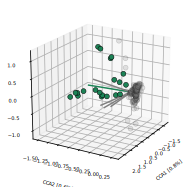

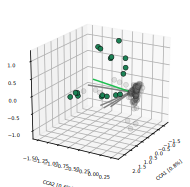

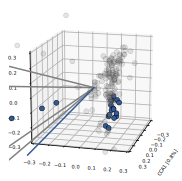

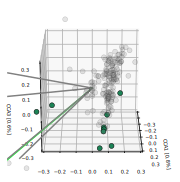

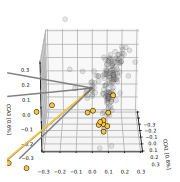

In [46]:
plot_ordn_ag('FliC', camera=dict(azim=30),lim=None).savefig('results/plots/ord_cca/FliC.svg')
plot_ordn_ag('FlgEHKL', camera=dict(azim=30), lim=None).savefig('results/plots/ord_cca/FlgEHKL.svg')
plot_ordn_ag('OprM', camera=dict(azim=15,elev=15)).savefig('results/plots/ord_cca/OprM.svg')
plot_ordn_ag('PilQ', camera=dict(azim=0)).savefig('results/plots/ord_cca/PilQ.svg')
plot_ordn_ag('T3SS', camera=dict(azim=0)).savefig('results/plots/ord_cca/T3SS.svg')

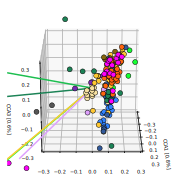

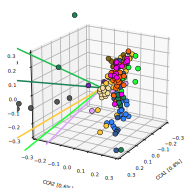

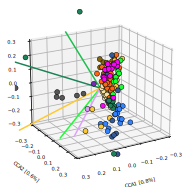

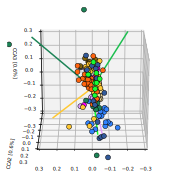

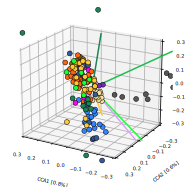

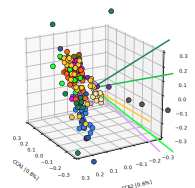

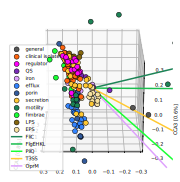

In [47]:
def plot_ordn_angle(camera):
    fig, ax = ordination_mpl(ordn, ex.selection_metadata, color='category', cmap=plotly_cmap, color_order = color_order, #color_order[1:],
                        alpha=1,edgecolors='#000000',
                        linewidth=0.5,
                         s=25,
                         # cmap=discrete_cmap(5,'viridis'), 
                         # color_order=sorted(ftf_all.obs['r'].unique()),
                         show_ticks=True,
                         xlim=[-0.3,0.3],
                         ylim=[-0.3,0.3],
                         zlim=[-0.3,0.3],
                         biplot=True,
                         biplot_cmap={k: (r/255.,g/255.,b/255.) for k,(r,g,b) in {
                             'FliC': (28, 131, 86),
                             'FlgEHKL': (28, 190, 79),
                             'PilQ':(22, 255, 50),
                             'T3SS':(255, 200, 50),
                             'OprM':(222, 160, 253),
                             None: (128, 128, 128),
                         }.items()},
                         camera={**dict(elev=20, azim=60, roll=0), **camera}, 
                             dims=['CCA1','CCA2','CCA3'],
                         fig_kw = dict(figsize=(3,3)), zoom=1);

    # plt.legend(loc='lower right')

for azim in [0, 30, 60, 90, 120, 150, 180]:
    plot_ordn_angle(dict(azim=azim))

plt.legend()